In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import pm

In [2]:
path = 'pictures/'
budynek1 = cv2.imread(path + 'budynek1.jpg')
budynek1 = cv2.cvtColor(budynek1, cv2.COLOR_BGR2RGB)
budynek2 = cv2.imread(path + 'budynek2.jpg')
budynek2 = cv2.cvtColor(budynek2, cv2.COLOR_BGR2RGB)
eiffel1 = cv2.imread(path + 'eiffel1.jpg')
eiffel1 = cv2.cvtColor(eiffel1, cv2.COLOR_BGR2RGB)
eiffel2 = cv2.imread(path + 'eiffel2.jpg')
eiffel2 = cv2.cvtColor(eiffel2, cv2.COLOR_BGR2RGB)
fontanna_pow = cv2.imread(path + 'fontanna_pow.jpg')
fontanna_pow = cv2.cvtColor(fontanna_pow, cv2.COLOR_BGR2RGB)
fontanna1 = cv2.imread(path + 'fontanna1.jpg')
fontanna1 = cv2.cvtColor(fontanna1, cv2.COLOR_BGR2RGB)
fontanna2 = cv2.imread(path + 'fontanna2.jpg')
fontanna2 = cv2.cvtColor(fontanna2, cv2.COLOR_BGR2RGB)
left_panorama = cv2.imread(path + 'left_panorama.jpg')
left_panorama = cv2.cvtColor(left_panorama, cv2.COLOR_BGR2RGB)
right_panorama = cv2.imread(path + 'right_panorama.jpg')
right_panorama = cv2.cvtColor(right_panorama, cv2.COLOR_BGR2RGB)

## Zadanie 1

In [3]:


def calculate_H(image, filter_size=7):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=filter_size)
    sobely = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=filter_size)

    Ixx = cv2.GaussianBlur(sobelx * sobelx, (filter_size, filter_size), 0)
    Iyy = cv2.GaussianBlur(sobely * sobely, (filter_size, filter_size), 0)
    Ixy = cv2.GaussianBlur(sobelx * sobely, (filter_size, filter_size), 0)

    K = 0.05
    H = np.zeros(img_gray.shape, dtype=np.float32)
    for y in range(img_gray.shape[0]):
        for x in range(img_gray.shape[1]):
            det = Ixx[y, x] * Iyy[y, x] - Ixy[y, x] * Ixy[y, x]
            trace = Ixx[y, x] + Iyy[y, x]
            H[y, x] = det - K * trace * trace

    H = (H - np.min(H)) / (np.max(H) - np.min(H)) 

    return H

def find_max(image , size , threshold) : # size - maximum filter mask size
    data_max = maximum_filter(image , size)
    maxima = (image == data_max)
    diff = image > threshold
    maxima[diff == 0] = 0
    return np.nonzero(maxima)

def draw_points(image, points):
    plt.figure()
    plt.imshow(image)
    plt.plot(points[1], points[0],'*', color='r')
    plt.show()

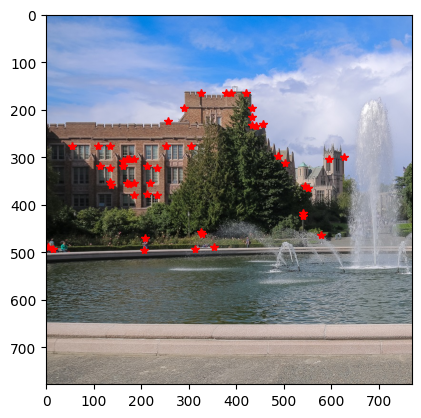

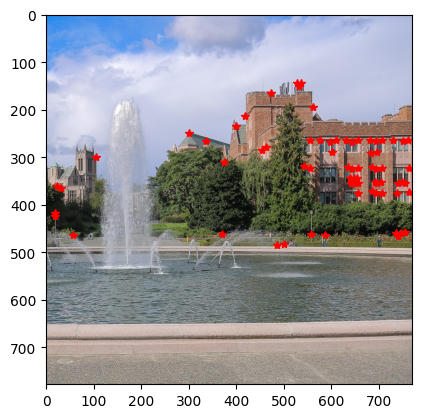

In [4]:
fontana1_H = calculate_H(fontanna1, 7)
maxima1 = find_max(fontana1_H, 7, 0.55)
draw_points(fontanna1, maxima1)

fontanna2_H = calculate_H(fontanna2, 7)
maxima2 = find_max(fontanna2_H, 7, 0.55)
draw_points(fontanna2, maxima2)

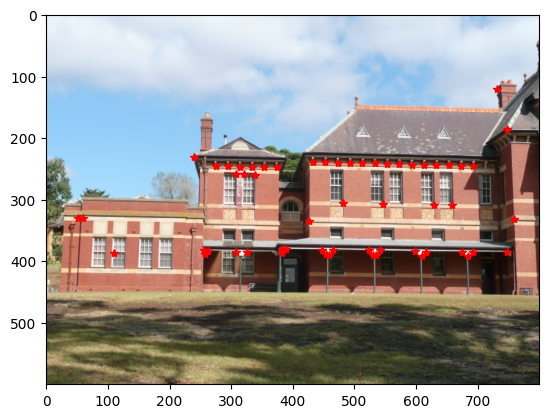

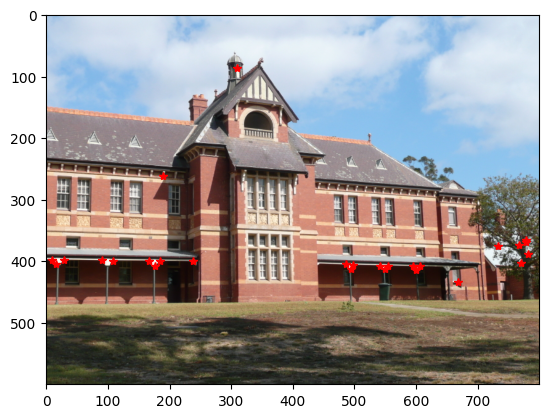

In [5]:
budynek1_H = calculate_H(budynek1, 7)
maxima3 = find_max(budynek1_H, 7, 0.55)
draw_points(budynek1, maxima3)

budynek2_H = calculate_H(budynek2, 7)
maxima4 = find_max(budynek2_H, 7, 0.55)
draw_points(budynek2, maxima4)

## Zadanie 2

In [6]:
def describe_points(image, points, size):
    height, width = image.shape[:2]
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    points = list(filter(lambda pt: pt[0] >= size and pt[0] < height - size 
                         and pt[1] >= size and pt[1] < width - size, zip(points[0], points[1])))
    
    descs = []
    for pt in points:
        patch = img_gray[pt[0] - size:pt[0] + size + 1, pt[1] - size:pt[1] + size + 1]
        descs.append(patch.flatten())

    return list(zip(descs, points))

In [7]:
def describe_points_2(image, points, size):
    height, width = image.shape[:2]
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    points = list(filter(lambda pt: pt[0] >= size and pt[0] < height - size 
                         and pt[1] >= size and pt[1] < width - size, zip(points[0], points[1])))

    descs = []
    for point in points:
        decs = image[point[0] - size:point[0] + size + 1, point[1] - size:point[1] + size + 1]
        desc = decs.flatten()

        mean = np.mean(desc)
        std = np.std(desc)
        desc = (desc - mean) / std

        descs.append(desc)

    return list(zip(descs, points))

In [8]:
def vector_difference(v1, v2):
    v1 = v1.astype(np.float32)
    v2 = v2.astype(np.float32)
    return np.sum(np.abs(v1 - v2))

def compare_descriptions(desc1, desc2, n):
    comparison = []

    for v1, pts1 in desc1:
        min_val = float('inf')
        best_val = None
        for v2, pts2 in desc2:
            diff = vector_difference(v1, v2)
            if diff < min_val:
                min_val = diff
                best_val = [pts1, pts2, diff]

        comparison.append(best_val)

    comparison.sort(key=lambda x: x[2])
    comparison = comparison[:n]

    return comparison

In [9]:
def match_points(img1, img2, n_points=20, size=7, threshold=0.5, version=1, gray=False):
    h1 = calculate_H(img1, size)
    maxima1 = find_max(h1, size, threshold)
    if version == 2:
        points1 = describe_points_2(img1, maxima1, size)
    else:
        points1 = describe_points(img1, maxima1, size)

    h2 = calculate_H(img2, size)
    maxima2 = find_max(h2, size, threshold)
    if version == 2:
        points2 = describe_points_2(img2, maxima2, size)
    else:
        points2 = describe_points(img2, maxima2, size)

    comparison = compare_descriptions(points1, points2, n_points)

    if gray:
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        # Ensure both are 3-channel RGB
        if len(img1.shape) == 2:
            img1 = np.stack([img1]*3, axis=-1)
        if len(img2.shape) == 2:
            img2 = np.stack([img2]*3, axis=-1)

    pm.plot_matches(img1, img2, comparison)

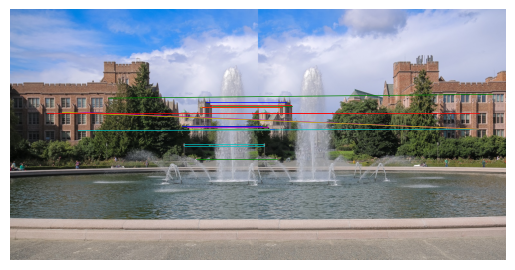

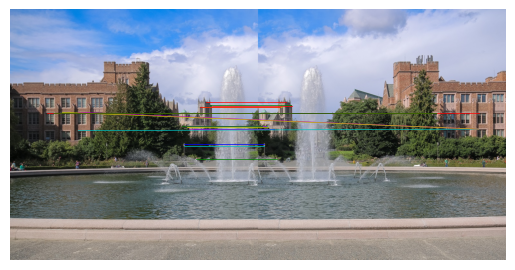

In [10]:
match_points(fontanna1, fontanna2, threshold=0.5, size=5)
match_points(fontanna1, fontanna2, threshold=0.5, size=5, version=2)

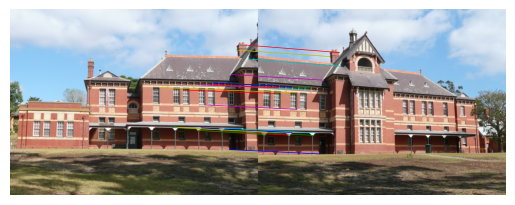

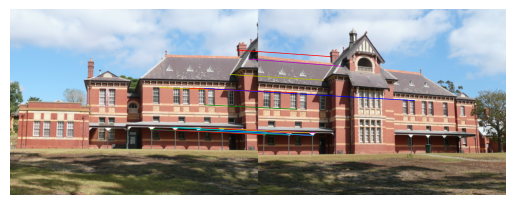

In [11]:
match_points(budynek1, budynek2, threshold=0.5, size=5)
match_points(budynek1, budynek2, threshold=0.5, size=5, version=2)

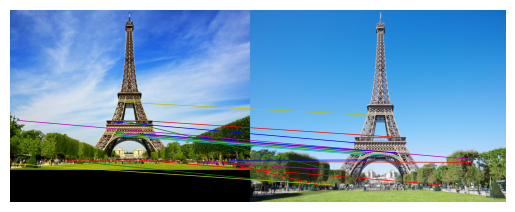

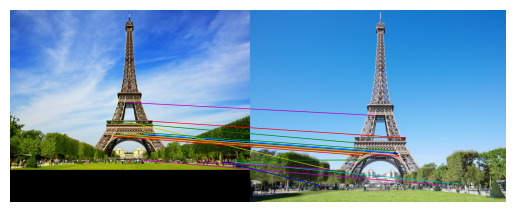

In [12]:
match_points(eiffel1, eiffel2, threshold=0.5, size=5)
match_points(eiffel1, eiffel2, threshold=0.5, size=5, version=2)

## Zadanie 3

In [13]:
def corner_score(intensities, center_intensity, threshold, n=9):
    brighter = 0
    darker = 0
    
    for intensity in intensities:
        if intensity > center_intensity + threshold:
            brighter += 1
            if brighter >= n:
                return True
        elif intensity < center_intensity - threshold:
            darker += 1
            if darker >= n:
                return True
            
    return False

In [14]:
def fast_detector(image, threshold, n=9, window_size=3):
    harr = calculate_H(image, 7)
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    height, width = img_gray.shape[:2]
    
    points = []
    harr_values = []

    for y in range(window_size, height - window_size):
        for x in range(window_size, width - window_size):
            center_intensity = img_gray[y, x]
            intensities = [
                img_gray[y - 3, x + 1],
                img_gray[y - 3, x],
                img_gray[y - 3, x - 1],
                img_gray[y - 2, x + 2],
                img_gray[y - 2, x - 2],
                img_gray[y - 1, x + 3],
                img_gray[y - 1, x - 3],
                img_gray[y, x + 3],
                img_gray[y, x - 3],
                img_gray[y + 1, x + 3],
                img_gray[y + 1, x - 3],
                img_gray[y + 2, x + 2],
                img_gray[y + 2, x - 2],
                img_gray[y + 3, x + 1],
                img_gray[y + 3, x],
                img_gray[y + 3, x - 1]
            ]

            if corner_score(intensities, center_intensity, threshold, n):
                points.append((y, x))
                harr_values.append(harr[y, x])

    return points, harr_values

In [15]:
def detect_fast_points(image, threshold=40, n_points=200):
    points, harr_values = fast_detector(image, threshold)
    
    harris_points = list(zip(points, harr_values))
    harris_points.sort(key=lambda x: x[1], reverse=True)
    harris_points = harris_points[:n_points]

    return {key: value for key, value in harris_points}

In [16]:
def non_max_suppression(image, points: dict):

    values_to_remove = []

    for point, value in points.items():
        if (point, value) in values_to_remove:
            continue

        y, x = point
        values = []
        for i in range(y - 1, y + 2):
            for j in range(x - 1, x + 2):
                if i < 0 or j < 0 or i >= image.shape[0] - 1 or j >= image.shape[1] - 1:
                    continue
                if (i, j) in points:
                    values.append(((i, j), points[(i, j)]))

        if len(values) > 1:
            values.sort(key=lambda x: x[1])
            for v in values[:-1]:
                if v not in values_to_remove:
                    values_to_remove.append(v)

    for v in values_to_remove:
        points.pop(v[0])

    return points

In [17]:
def filter_out_too_small_surrounding(image, filtered_points, size=16):
    y, x = image.shape[:2]

    points = list(filter(lambda pt: pt[0][0] >= size and pt[0][0] < y - size
                         and pt[0][1] >= size and pt[0][1] < x - size, list(zip(filtered_points.keys(), filtered_points.values()))))    

    return points

In [18]:
def chose_n_best_points(filtered_points, n=30):
    if len(filtered_points) <= n:
        return filtered_points
    filtered_points.sort(key=lambda x: x[1], reverse=True)
    filtered_points = filtered_points[:n]
    return filtered_points

In [19]:
def centroids(image, points, size=9):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_gray = img_gray.astype(np.int32)

    centroids = []
    thetas = []

    for point, value in points:
        y, x = point
        m00 = 0
        m01 = 0
        m10 = 0
        for i in range(y - size, y + size + 1):
            for j in range(x - size, x + size + 1):
                dy = y - i
                dx = x - j
                distance2 = dx * dx + dy * dy
                if distance2 <= size * size:
                    m00 += img_gray[i, j]
                    m01 += -dy * img_gray[i, j]
                    m10 += -dx * img_gray[i, j]
        C = (m10 / m00, m01 / m00)
        theta = np.arctan2(m01, m10)
        centroids.append(C)
        thetas.append(theta)

    return centroids, thetas

In [20]:
def load_brief(image_patch, theta):
    score = []
    with open('orb_descriptor_positions.txt', 'r') as f:
        for line in f:
            values = line.split(' ')
            values = [float(x) for x in values]

            u = values[:2]
            v = values[2:]

            u[0] = int(np.cos(theta)*u[0] + np.sin(theta)*u[1])
            u[1] = int(np.sin(theta)*u[1] + np.cos(theta)*u[0])

            v[0] = int(np.cos(theta)*v[0] + np.sin(theta)*v[1])
            v[1] = int(np.sin(theta)*v[1] + np.cos(theta)*v[0])

            u = tuple(u)
            v = tuple(v)

            if image_patch[u] < image_patch[v]:
                score.append(1)
            else:
                score.append(0)

    return score

def describe_points_brief(image, points, thetas, size=15):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    scores = []
    points = [x[0] for x in points] # remove values, only points
    for i, point in enumerate(points):
        y, x = point
        theta = thetas[i]
        patch = img_gray[y - size: y + size + 1, x - size: x + size + 1]
        patch_gauss = cv2.GaussianBlur(patch, (5, 5), 0)
        brief_scorescore = load_brief(patch_gauss, theta)
        scores.append(brief_scorescore)

    return scores

In [21]:
def hamming(arr1, arr2):
    val = 0
    for i in range(len(arr1)):
        if i >= len(arr2):
            break
        if arr1[i] != arr2[i]:
            val += 1
    return val

def compare_brief_descriptions(scores1, points1, scores2, points2, n=30):
    comparison = []

    for p1, s1 in zip(points1, scores1):
        min_val = float('inf')
        best_val = None
        for p2, s2 in zip(points2, scores2):
            diff = hamming(s1, s2)
            if diff < min_val:
                min_val = diff
                best_val = [p1, p2, diff]

        comparison.append(best_val)

    comparison.sort(key=lambda x: x[2])
    comparison = comparison[:n]

    return comparison

In [22]:
def orb(image1, threshold=50, n_best=256):
    points1 = detect_fast_points(image1, threshold)
    points1 = non_max_suppression(image1, points1)
    points1 = filter_out_too_small_surrounding(image1, points1)
    points1 = chose_n_best_points(points1, n_best)
    centroids1, thetas1 = centroids(image1, points1)
    scores1 = describe_points_brief(image1, points1, thetas1)
    points1 = [x[0] for x in points1]
    
    return scores1, points1

In [23]:
def two_image_orb(image1, image2, threshold=50, n_best=20, gray=False):
    scores1, points1 = orb(image1, threshold, n_best)
    scores2, points2 = orb(image2, threshold, n_best)

    comparison = compare_brief_descriptions(scores1, points1, scores2, points2)

    if gray:
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    pm.plot_matches(image1, image2, comparison)

In [24]:
def scaled_images(img, scale, n=3):
    imgs = [img]
    for i in range(n):
        img = cv2.resize(img, (0, 0), fx=1/scale, fy=1/scale)
        imgs.append(img)
    return imgs

def scale_point(pt, scale):
    return (pt[0] * scale, pt[1] * scale)

def two_image_orb_pyramid(image1, image2, scale=2, gray=False):
    scaled_images_1 = scaled_images(image1, scale)
    scaled_images_2 = scaled_images(image2, scale)

    scores_1_s, points_1_s, scores_2_s, points_2_s = [], [], [], []

    for i in range(len(scaled_images_1)):
        scores1, points1 = orb(scaled_images_1[i])
        scores2, points2 = orb(scaled_images_2[i])

        points1 = [x * 2**i for x in points1]
        points2 = [x * 2**i for x in points2]

        for j in range(len(scores1)):
            scores_1_s.append(scores1[j])
            points_1_s.append(scale_point(points1[j], scale**i))

        for j in range(len(scores2)):
            scores_2_s.append(scores2[j])
            points_2_s.append(scale_point(points2[j], scale**i))

    comparison = compare_brief_descriptions(scores_1_s, points_1_s, scores_2_s, points_2_s)

    if gray:
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    pm.plot_matches(image1, image2, comparison)

/tmp/ipykernel_46002/2930756784.py:6: RuntimeWarning: overflow encountered in scalar add
  if intensity > center_intensity + threshold:
/tmp/ipykernel_46002/2930756784.py:10: RuntimeWarning: overflow encountered in scalar subtract
  elif intensity < center_intensity - threshold:


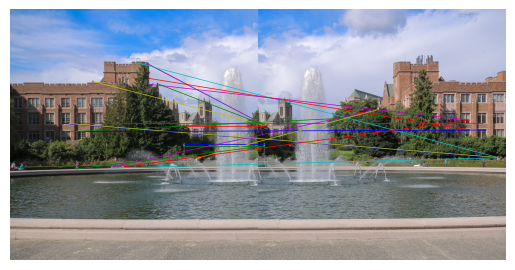

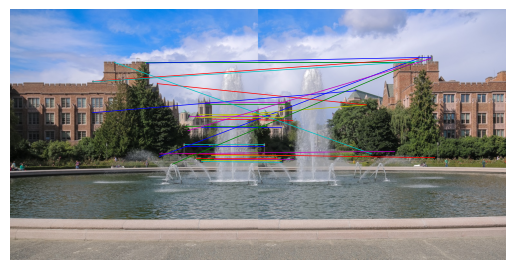

In [25]:
two_image_orb(fontanna1, fontanna2)
two_image_orb_pyramid(fontanna1, fontanna2)

/tmp/ipykernel_46002/2930756784.py:6: RuntimeWarning: overflow encountered in scalar add
  if intensity > center_intensity + threshold:
/tmp/ipykernel_46002/2930756784.py:10: RuntimeWarning: overflow encountered in scalar subtract
  elif intensity < center_intensity - threshold:


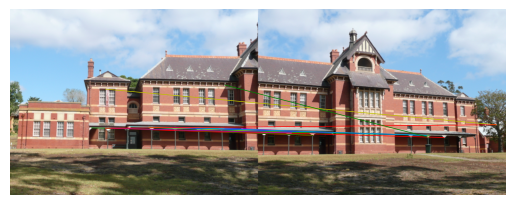

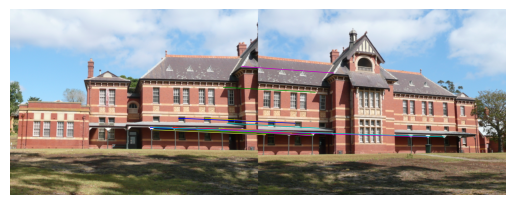

In [26]:
two_image_orb(budynek1, budynek2)
two_image_orb_pyramid(budynek1, budynek2)

/tmp/ipykernel_46002/2930756784.py:6: RuntimeWarning: overflow encountered in scalar add
  if intensity > center_intensity + threshold:
/tmp/ipykernel_46002/2930756784.py:10: RuntimeWarning: overflow encountered in scalar subtract
  elif intensity < center_intensity - threshold:


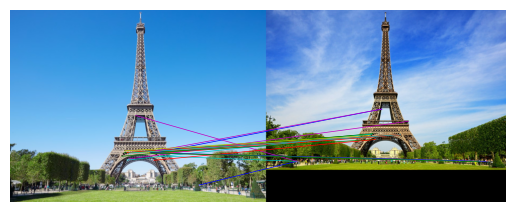

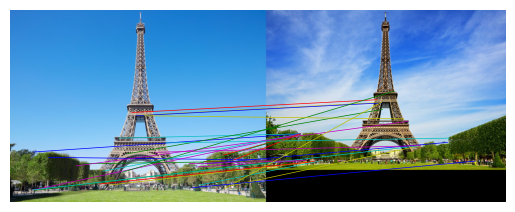

In [27]:
two_image_orb(eiffel2, eiffel1)
two_image_orb_pyramid(eiffel2, eiffel1)

## Zadanie 4

In [40]:
left_panorama_gray = cv2.cvtColor(left_panorama, cv2.COLOR_RGB2GRAY)
right_panorama_gray = cv2.cvtColor(right_panorama, cv2.COLOR_RGB2GRAY)

sift = cv2.ORB_create()

key_points_L, descriptors_1 = sift.detectAndCompute(left_panorama_gray, None)
key_points_R, descriptors_2 = sift.detectAndCompute(right_panorama_gray, None)

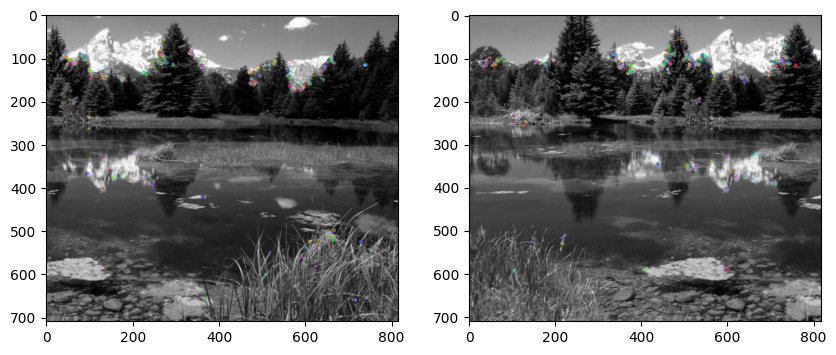

In [41]:
kp1 = cv2.drawKeypoints(left_panorama_gray, key_points_L, None,)
kp2 = cv2.drawKeypoints(right_panorama_gray, key_points_R, None)

plt.subplots(1, 2, figsize=(10, 10))
plt.subplot(121)
plt.imshow(kp1)
plt.subplot(122)
plt.imshow(kp2)
plt.show()

In [42]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

knn_matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)

best_matches = []
for m, n in knn_matches:
    if m.distance < 0.75 * n.distance:
        best_matches.append(m)

In [43]:
m = cv2.drawMatches(left_panorama_gray, key_points_L, right_panorama_gray, key_points_R, best_matches, None)

In [44]:
key_points_L = np.float32([kp.pt for kp in key_points_L])
key_points_R = np.float32([kp.pt for kp in key_points_R])

ptsA = np.float32([key_points_L[m.queryIdx] for m in best_matches])
ptsB = np.float32([key_points_R[m.trainIdx] for m in best_matches])

homography_matrix, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)

result = cv2.warpPerspective(left_panorama, homography_matrix, (left_panorama.shape[1] + right_panorama.shape[1], right_panorama.shape[0]))

result[0:right_panorama.shape[0], 0:right_panorama.shape[1]] = right_panorama

result = result[:, :1280]

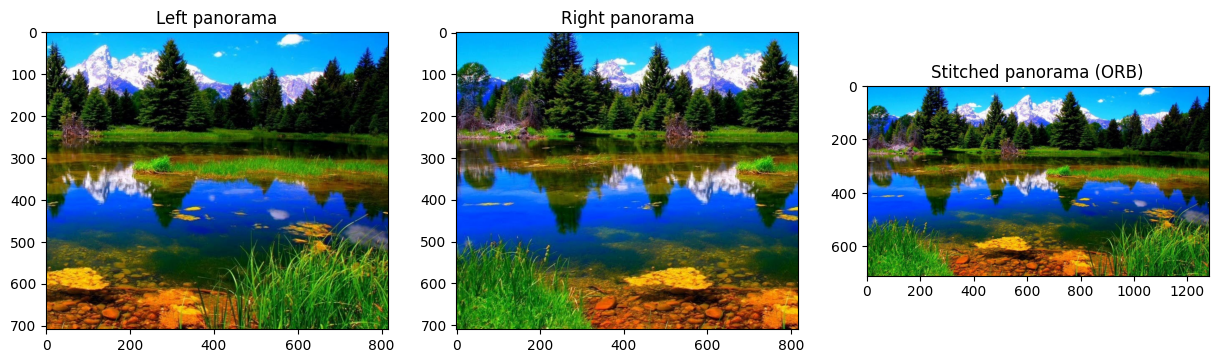

In [45]:
plt.subplots(1, 3, figsize=(15, 10))
plt.subplot(131)
plt.imshow(left_panorama)
plt.title('Left panorama')
plt.subplot(132)
plt.imshow(right_panorama)
plt.title('Right panorama')
plt.subplot(133)
plt.imshow(result)
plt.title('Stitched panorama (ORB)')
plt.show()

## Zadanie 5

In [46]:
def sift_visualize(img_left, img_right):
    left_panorama_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
    right_panorama_gray = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()

    key_points_L, descriptors_1 = sift.detectAndCompute(left_panorama_gray, None)
    key_points_R, descriptors_2 = sift.detectAndCompute(right_panorama_gray, None)

    kp1 = cv2.drawKeypoints(left_panorama_gray, key_points_L, None,)
    kp2 = cv2.drawKeypoints(right_panorama_gray, key_points_R, None)

    plt.subplots(1, 2, figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(kp1)
    plt.subplot(122)
    plt.imshow(kp2)
    plt.show()

    matcher = cv2.BFMatcher(cv2.NORM_L2)

    knn_matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)

    best_matches = []
    for m, n in knn_matches:
        if m.distance < 0.75 * n.distance:
            best_matches.append(m)
    m = cv2.drawMatches(left_panorama_gray, key_points_L, right_panorama_gray, key_points_R, best_matches, None)

    key_points_L = np.float32([kp.pt for kp in key_points_L])
    key_points_R = np.float32([kp.pt for kp in key_points_R])

    ptsA = np.float32([key_points_L[m.queryIdx] for m in best_matches])
    ptsB = np.float32([key_points_R[m.trainIdx] for m in best_matches])

    homography_matrix, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)

    result = cv2.warpPerspective(left_panorama, homography_matrix, (left_panorama.shape[1] + right_panorama.shape[1], right_panorama.shape[0]))

    result[0:right_panorama.shape[0], 0:right_panorama.shape[1]] = right_panorama

    result = result[:, :1280]

    plt.subplots(1, 3, figsize=(15, 10))
    plt.subplot(131)
    plt.imshow(left_panorama)
    plt.title('Left panorama')
    plt.subplot(132)
    plt.imshow(right_panorama)
    plt.title('Right panorama')
    plt.subplot(133)
    plt.imshow(result)
    plt.title('Stitched panorama (SIFT)')
    plt.show()

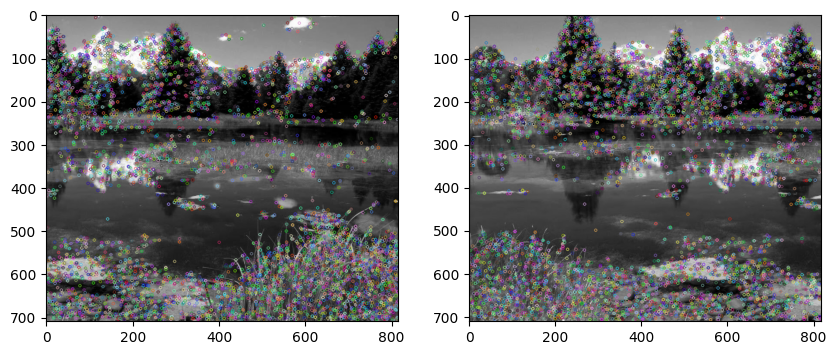

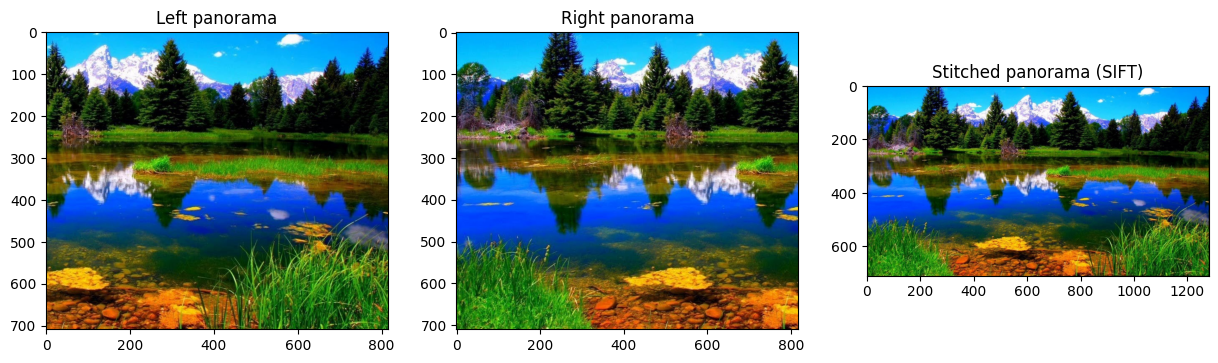

In [47]:
sift_visualize(left_panorama, right_panorama)